In [1]:
import tensorflow.compat.v1 as tf
from tensorflow.keras import activations
tf.disable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2022-11-25 11:58:15.768188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BasicRNNCell(tf.compat.v1.nn.rnn_cell.RNNCell):

    def __init__(
        self,
        num_units,
        activation=None,
        reuse=None,
        name=None,
        dtype=None,
        **kwargs,
    ):
        super().__init__(_reuse=reuse, name=name, dtype=dtype, **kwargs)

        self._num_units = num_units
        if activation:
            self._activation = activations.get(activation)
        else:
            self._activation = tf.tanh

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def build(self, inputs_shape):
        if inputs_shape[-1] is None:
            raise ValueError(
                "Expected inputs.shape[-1] to be known, "
                f"received shape: {inputs_shape}"
            )

        input_depth = inputs_shape[-1]
        self._kernel = self.add_weight(
            "kernel",
            shape=[input_depth + self._num_units, self._num_units],
        )
        self._bias = self.add_weight(
            "bias",
            shape=[self._num_units],
            initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype),
        )

        self.built = True

    def call(self, inputs, state):
        """Most basic RNN: output = new_state = act(W * input + U * state +
        B)."""

        gate_inputs = tf.matmul(tf.concat([inputs, state], 1), self._kernel)
        gate_inputs = tf.nn.bias_add(gate_inputs, self._bias)
        output = self._activation(gate_inputs)
        return output, output

    def get_config(self):
        config = {
            "num_units": self._num_units,
            "activation": activations.serialize(self._activation),
            "reuse": self._reuse,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
n_windows = 20   
n_input =  1
n_output = 1
size_train = 201
tf.reset_default_graph()
r_neuron = 120   

In [4]:
def create_ts(start = '2001', n = 201, freq = 'M'):
    rng = pd.date_range(start=start, periods=n, freq=freq)
    ts = pd.Series(np.random.uniform(-18, 18, size=len(rng)), rng).cumsum()
    return ts
ts = create_ts(start = '2001', n = 222)

In [5]:
series = np.array(ts)
train = series[:size_train]
test = series[size_train:]
print(train.shape, test.shape)

(201,) (21,)


In [6]:
x_data = train[:size_train-1]
X_batches = x_data.reshape(-1, n_windows, n_input)
def create_batches(df, windows, input, output):
    ## Create X         
        x_data = train[:size_train-1] # Select the data
        X_batches = x_data.reshape(-1, windows, input)  # Reshape the data 
    ## Create y
        y_data = train[n_output:size_train]
        y_batches = y_data.reshape(-1, windows, output)
        return X_batches, y_batches

In [7]:
X_batches, y_batches = create_batches(df = train,
                                      windows = n_windows,
                                      input = n_input,
                                      output = n_output)

In [8]:
X_test, y_test = create_batches(df = test, windows = 20,input = 1, output = 1)
print(X_test.shape, y_test.shape)

(10, 20, 1) (10, 20, 1)


In [9]:
X = tf.placeholder(tf.float32, [None, n_windows, n_input])   
y = tf.placeholder(tf.float32, [None, n_windows, n_output])

basic_cell = BasicRNNCell(r_neuron, activation=tf.nn.relu) 
# basic_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(r_neuron, activation=tf.nn.relu) 

rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)              
stacked_rnn_output = tf.reshape(rnn_output, [-1, r_neuron])          
stacked_outputs = tf.layers.dense(stacked_rnn_output, n_output)       
outputs = tf.reshape(stacked_outputs, [-1, n_windows, n_output])

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/var/folders/1_/_n_tsfn5339_d17486wc50nw0000gn/T/ipykernel_98819/225924246.py:9: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.layers.dense(stacked_rnn_output, n_output)


In [10]:
learning_rate = 0.001  
 
loss = tf.reduce_sum(tf.square(outputs - y))    
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)         
training_op = optimizer.minimize(loss) 

In [11]:
init = tf.global_variables_initializer() 
iteration = 1500 

with tf.Session() as sess:
    init.run()
    for iters in range(iteration):
        sess.run(training_op, feed_dict={X: X_batches, y: y_batches})
        if iters % 150 == 0:
            mse = loss.eval(feed_dict={X: X_batches, y: y_batches})
            print(iters, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})

2022-11-25 11:58:19.162682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 11:58:19.167229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


0 	MSE: 2426966.8
150 	MSE: 49917.598
300 	MSE: 15099.124
450 	MSE: 10036.301
600 	MSE: 7335.3394
750 	MSE: 6538.5835
900 	MSE: 5137.2163
1050 	MSE: 4900.088
1200 	MSE: 4023.4592
1350 	MSE: 3496.1562


/var/folders/1_/_n_tsfn5339_d17486wc50nw0000gn/T/ipykernel_98819/2606641324.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
/var/folders/1_/_n_tsfn5339_d17486wc50nw0000gn/T/ipykernel_98819/2606641324.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')


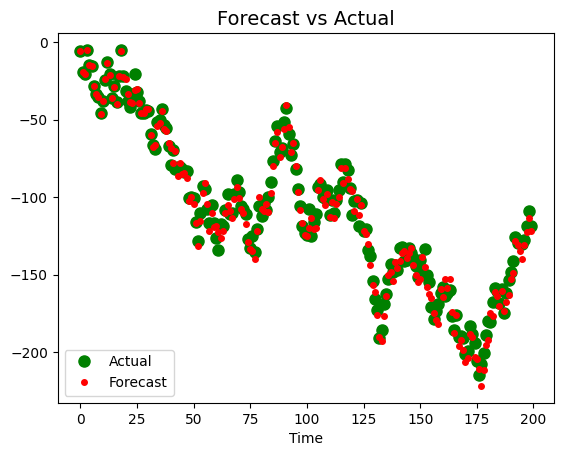

In [12]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')
plt.legend(loc="lower left")
plt.xlabel("Time")

plt.show()